<a href="https://colab.research.google.com/github/KoMurase/interest/blob/master/%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 学習済みのVGG-16モデルをロード
# 初めて実行する際は、学習済みパラメータをダウンロードするため、実行に時間がかかります

# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:18<00:00, 29364515.48it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
# 入力画像の前処理のクラス
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):
        return self.base_transform(img)

In [0]:
import glob 
import os.path as osp
import random
import numpy as np 
import json 
from PIL import Image 
from tqdm import tqdm 
import matplotlib.pyplot as plt 
%matplotlib inline 

import torch 
import torch.nn as nn 
import torch.optim as optim
import torch.utils.data as data 
import torchvision 
from torchvision import models ,transforms 



In [0]:
#乱数シード
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)


In [0]:
#入力画像の前処理をするクラス
#訓練時と推論時で処理が異なる

class ImageTransform():
  
  """
  resize : int = リサイズ先の画像の大きさ
  mean : (R,G,B)　各色チャネルの平均値
  std : (R,G,B)   各色チャネルの標準偏差
  """
  def __init__(self,resize,mean,std):
    self.data_transform = {
        'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize,scale=(0.5,1.0)),  #データオーギュメンテーション
            transforms.RandomHorizontalFlip(),                    #データオーギュメンテーション
            transforms.ToTensor(),                   #Tensor(多次元配列を扱うためのデータ型)に変換
            transforms.Normalize(mean,std)   #標準化            
        ]),
        'val' : transforms.Compose([
            transforms.Resize(resize), #リサイズ
            transforms.CenterCrop(resize), #画像中央をresize x resizeで切り取る
            transforms.ToTensor(), #テンソルに変換
            transforms.Normalize #標準化
        ])
    }
  
  def __call__(self,img,phase='train'):
    
    '''
    Parameters
    
    phase : 'train' or 'val'   = 前処理モードの指定
    '''
    return self.data_transform[phase](img)

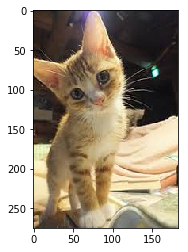

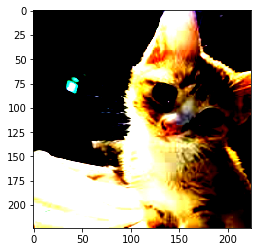

In [0]:
#訓練時の前処理動作の確認
#実行するたびに動作が変わる

image_file_path = '/content/ダウンロード.jpg'

'''
上　'/content/goldenretriever-3724972_640.jpg'　GitHubから取ってきた犬

'''
img = Image.open(image_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229,0.224,0.225)

transform = ImageTransform(size,mean,std)
img_transformed = transform(img,phase='train')

img_transformed = img_transformed.numpy().transpose((1,2,0))
img_transformed = np.clip(img_transformed,0,1)
plt.imshow(img_transformed)
plt.show()

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def make_datapath_list(phase = 'train'):
  rootpath = './data/hymenoptera_data/'
  target_path = osp.join(rootpath+phase+'/**/*.jpg')
  print(target_path)
  
  path_list = []
  
  for path in glob.glob(target_path):
    path_list.append(path)
    
  return path_list

#実行
train_list = make_datapath_list(phase='train')
val_list = make_datapath_list(phase='val')

train_list

./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


[]

In [0]:
#画像ファイルを公式もしくは自分で生成するmemo